# Naive approach random_forest + optuna - holidays

In [11]:
model_name = 'random_forest_with_holidays_no_2020'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

df_train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


### Features

In [7]:
# helper functions
import requests
import holidays

# magical constants

def add_magical_constants(df):
    coef_c = {'Argentina': 4.23, 'Spain': 1.500, 'Japan': 1.14, 'Estonia': 1.62, 'Canada': 0.87}
    for c, country in enumerate(df['country'].unique()):
        df.loc[(df['country'] == country), 'num_sold'] *= coef_c[country]
    return df

# gdp feature

def get_gdp_per_capita(country,year):
    alpha3 = {'Argentina':'ARG','Canada':'CAN','Estonia':'EST','Japan':'JPN','Spain':'ESP'}
    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(alpha3[country],year)
    response = requests.get(url).json()
    return response[1][0]['value']

def create_gdp_df(df):
    gdp = []
    for country in df.country.unique():
        row = []
        for year in range(2017,2023):
            row.append(get_gdp_per_capita(country,year))
        gdp.append(row)

    gdp = np.array(gdp)
    gdp /= np.sum(gdp,axis=0)

    rel_gdp_df = pd.DataFrame(gdp,index=df.country.unique(),columns=range(2017,2023))
    return rel_gdp_df

def add_gdp_feature(df):
    rel_gdp_df_0 = create_gdp_df(df)
    rel_gdp_df = rel_gdp_df_0.reset_index(names="country")
    rel_gdp_df = pd.melt(rel_gdp_df, id_vars='country', value_vars=[2017, 2018, 2019, 2020, 2021, 2022])
    rel_gdp_df.columns = ['country', 'year', 'rel_gdp']
    rel_gdp_df['year'] = rel_gdp_df['year'].astype(int)
    df = df.merge(rel_gdp_df, on=['year', 'country'], how='left')
    return df

# holidays feature

def create_holidays_df():
    years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

    countries = {
        "AR": "Argentina",
        "CA": "Canada",
        "EE": "Estonia",
        "ES": "Spain",
        "JP": "Japan"
    }


    Argentina_holidays = holidays.CountryHoliday('AR', years=years)
    Canada_holidays = holidays.CountryHoliday('CA', years=years)
    Estonia_holidays = holidays.CountryHoliday('EE', years=years)
    Spain_holidays = holidays.CountryHoliday('ES', years=years)
    Japan_holidays = holidays.CountryHoliday('JP', years=years)

    all_holidays = [Argentina_holidays, Canada_holidays, Estonia_holidays, Spain_holidays, Japan_holidays]



    holidays_dfs = []
    for country_holidays in all_holidays:
        holidays_dates = []
        for date in country_holidays:
            holidays_dates.append(date)

        holidays_dates = list(set(holidays_dates))

        hdf = pd.DataFrame(holidays_dates, columns=['date'])
        hdf['country'] = countries[country_holidays.country]

        holidays_dfs.append(hdf)

    holidays_df = pd.concat(holidays_dfs)

    holidays_df['is_holiday'] = True

    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    return holidays_df

def add_holiday_feature(df):
    holidays_df = create_holidays_df()
    df = df.merge(holidays_df, on=['date', 'country'], how='left')
    df['is_holiday'] = df['is_holiday'].fillna(False)
    df['is_holiday'] = df['is_holiday'].astype(int)
    return df


def transform_date(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

def create_features(df):
    # split date into year, month, day
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # week number
    df['week_number'] = df['date'].dt.isocalendar().week.astype(int)
    
    # day of week
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.day
    # weekend
    df['weekend'] = (df['date'].dt.weekday >=4).astype(int)

    df['country'] = df['country'].astype('category')
    df['store'] = df['store'].astype('category')
    df['product'] = df['product'].astype('category')

    # remove march 2020 - june 2020
    df = df[(df['date'] < '2020-03-01') | (df['date'] > '2020-06-30')]

    return df

def encode_cat_variables(df):
    categorical_features = ["country", "store", "product"]
    df = pd.get_dummies(df, columns=categorical_features)
    return df

def seasonality_features(df):
    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)
    df['day_sin'] = np.sin(2*np.pi*df.dayofmonth/31)
    df['day_cos'] = np.cos(2*np.pi*df.dayofmonth/31)
    return df

def SMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
import optuna


df_train = transform_date(df_train)
df_train = create_features(df_train)
df_train = seasonality_features(df_train)
df_train = add_gdp_feature(df_train)
df_train = add_holiday_feature(df_train)
df_train = encode_cat_variables(df_train)


df_test_0 = transform_date(df_test)
df_test_0 = create_features(df_test_0)
df_test_0 = seasonality_features(df_test_0)
df_test_0 = add_gdp_feature(df_test_0)
df_test_0 = add_holiday_feature(df_test_0)
df_test_0 = encode_cat_variables(df_test_0)

model_features = df_train.columns.tolist()
model_features.remove("num_sold")
model_features.remove("date")

# we pick the last half year of 2021 as validation set

X_train = df_train[df_train["date"] < "2021-06-01"][model_features]
y_train = df_train[df_train["date"] < "2021-06-01"]["num_sold"]

X_val = df_train[df_train["date"] >= "2021-06-01"][model_features]
y_val = df_train[df_train["date"] >= "2021-06-01"]["num_sold"]

cat_features_indices = np.where((X_train.dtypes == "category") | (X_train.dtypes == "object"))[0]
cat_features_indices

def objective(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000),
        max_depth=trial.suggest_int('max_depth', 10, 110),
        bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
        min_samples_leaf=trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
        min_samples_split=trial.suggest_categorical('min_samples_split', [2, 5, 10]),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(
        X_train, y_train,
    )

    return SMAPE(y_val, np.round(model.predict(X_val)))


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)

best_hyperparams = study.best_params

[I 2023-07-30 08:31:37,131] A new study created in memory with name: no-name-bf86be7c-1255-4656-837b-76c10fccd6b4
[I 2023-07-30 08:31:42,049] Trial 0 finished with value: 8.433685184601579 and parameters: {'n_estimators': 270, 'max_depth': 20, 'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 8.433685184601579.
[I 2023-07-30 08:31:48,116] Trial 1 finished with value: 8.524062891989255 and parameters: {'n_estimators': 342, 'max_depth': 74, 'bootstrap': True, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 8.433685184601579.
[I 2023-07-30 08:31:51,624] Trial 2 finished with value: 8.487872153131173 and parameters: {'n_estimators': 207, 'max_depth': 16, 'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 8.433685184601579.
[I 2023-07-30 08:32:08,135] Trial 3 finished with value: 8.707896000980313 and 

KeyboardInterrupt: 

In [9]:
best_hyperparams = study.best_params

In [12]:
# split into train and validation

results_smape = []
results_r2 = []
results_mse = []


N_SPLITS = 5

for train_index, val_index in TimeSeriesSplit(n_splits=N_SPLITS).split(df_train):
    X_train = df_train.iloc[train_index][model_features]
    y_train = df_train.iloc[train_index]['num_sold']

    X_val = df_train.iloc[val_index]
    y_val = df_train.iloc[val_index]['num_sold']

    model = RandomForestRegressor(**best_hyperparams)
    model.fit(X_train, y_train)

    # evaluate on validation set
    y_pred = np.round(model.predict(X_val[model_features]))

    smape = SMAPE(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    results_smape.append(smape)
    results_r2.append(r2)
    results_mse.append(mse)
    del model

print("Cross validated results:")

print("SMAPE: %s" % results_smape)
print("R2: %s" % results_r2)
print("MSE: %s" % results_mse)

print("Mean results:")
print("SMAPE: %.4f" % np.mean(results_smape))
print("R2: %.4f" % np.mean(results_r2))
print("MSE: %.4f" % np.mean(results_mse))


# add a row with results to csv file leaderboard.csv

row = [model_name, np.mean(results_smape), np.mean(results_r2), np.mean(results_mse)]
with open('leaderboard.csv', 'a') as fd:
    import csv
    fd.write('\n')
    writer = csv.writer(fd, delimiter=',', lineterminator=';\n')
    writer.writerow(row)

Cross validated results:
SMAPE: [12.528089881579511, 9.128489755658151, 8.682332589491928, 9.447543865923382, 7.581112954910026]
R2: [0.9680310409944501, 0.9850608306580667, 0.9868568707321116, 0.9815396794691711, 0.978191690135681]
MSE: [1124.241220657277, 530.067558685446, 443.41723004694836, 623.0309389671362, 856.7151643192489]
Mean results:
SMAPE: 9.4735
R2: 0.9799
MSE: 715.4944


In [16]:
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

df_train = transform_date(df_train)
df_train = create_features(df_train)
df_train = seasonality_features(df_train)
df_train = add_gdp_feature(df_train)
df_train = add_holiday_feature(df_train)
df_train = encode_cat_variables(df_train)


df_test_0 = transform_date(df_test)
df_test_0 = create_features(df_test_0)
df_test_0 = seasonality_features(df_test_0)
df_test_0 = add_gdp_feature(df_test_0)
df_test_0 = add_holiday_feature(df_test_0)
df_test_0 = encode_cat_variables(df_test_0)

X_train = df_train[model_features]
y_train = df_train["num_sold"]

X_test = df_test_0[model_features]

KeyError: 'num_sales'

In [18]:
X_train = df_train[model_features]
y_train = df_train["num_sold"]

X_test = df_test_0[model_features]

Submission saved to seasonality_holidays_no_2020_rfr_submission.csv


<Axes: xlabel='date', ylabel='num_sold'>

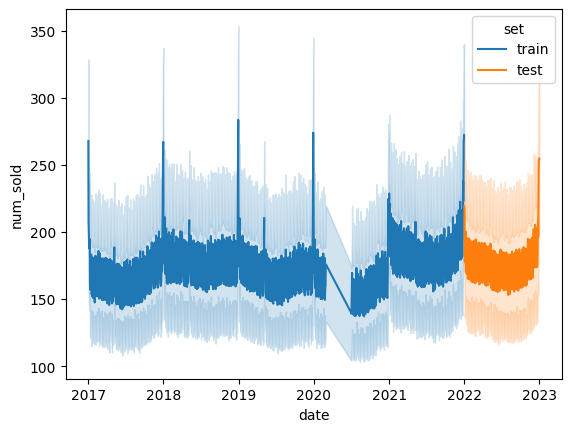

In [19]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import Pool, CatBoostRegressor


model_rfr = RandomForestRegressor(**best_hyperparams)
name = "seasonality_holidays_no_2020_rfr"
model_rfr.fit(X_train, y_train)

Submission saved to seasonality_holidays_no_2020_rfr_submission.csv


<Axes: xlabel='date', ylabel='num_sold'>

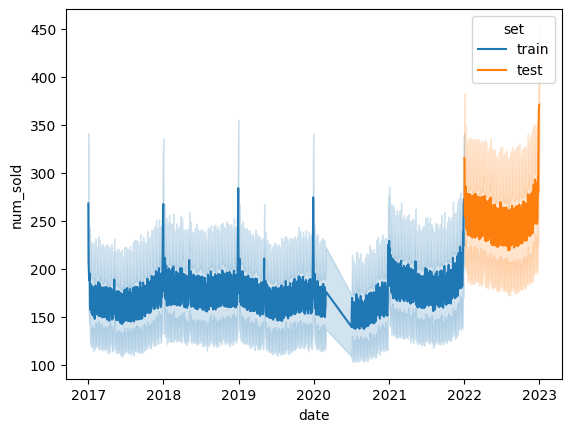

In [21]:
df_test['num_sold'] = np.round(model_rfr.predict(X_test)).astype(int)


df_test = add_magical_constants(df_test)

submission_df = df_test[['id', 'num_sold']]
submission_df.to_csv(f'{name}_submission.csv', index=False)
print(f"Submission saved to {name}_submission.csv")
      
# merge df_train with df_test
df_train['set'] = 'train'
df_test['set'] = 'test'
df_temp = pd.concat([df_train, df_test], axis=0, ignore_index=True)
sns.lineplot(x='date', y='num_sold', hue='set', data=df_temp)